In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
runs = ["cf", "ba"]
ndays = 20
run_dir = "/glade/scratch/sturbeville/DPSCREAM_simulations/"


In [2]:
file="h0_varnames_3Dlev"
varnames = open(file,"r").read().split("\n")  
varnames

['ANRAIN',
 'ANSNOW',
 'AQRAIN',
 'AQSNOW',
 'AREI',
 'AREL',
 'AWNC',
 'AWNI',
 'BRUNT',
 'BVRIM',
 'CLDICE',
 'CLDLIQ',
 'CLDRIM',
 'CLOUD',
 'CLOUDFRAC_ICE_MICRO',
 'CLOUDFRAC_LIQ_MICRO',
 'CLOUDFRAC_RAIN_MICRO',
 'CONCLD',
 'DCQ',
 'DTCOND',
 'ICE_CLOUD_FRAC',
 'ICIMR',
 'ICWMR',
 'ISOTROPY',
 'IWC',
 'LIQ_CLOUD_FRAC',
 'NUMICE',
 'NUMLIQ',
 'NUMRAI',
 'OMEGA',
 'OMEGAT',
 'PRECIPITATING_ICE_FRAC',
 'Q',
 'QDIFF',
 'QRL',
 'QRS',
 'RAINQM',
 'RELHUM',
 'SHOC_MIX',
 'SHOC_QL',
 'SHOC_TKE',
 'T',
 'TDIFF',
 'THL2_RES',
 'TK',
 'TKH',
 'TOT_CLOUD_FRAC',
 'U',
 'V',
 'Z3']

saving to plots/compare_runs_NUMICE_cf-ba.png


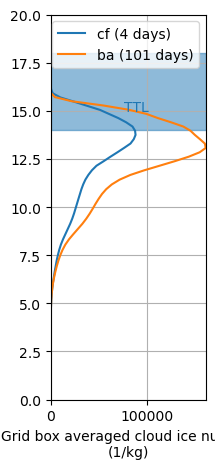

In [14]:
var = "NUMICE"
logscale=False
fig, ax = plt.subplots(1,1, figsize=(2,5))
savename=var+"_"
if logscale:
    xmin, xmax = 1e-8,1e-4
    ax.set_xscale("log")
else:
    xmin, xmax = 0,0
for i in range(len(runs)):
    ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i],runs[i]))
    units = ds[var].units
    long_name = ds[var].long_name
    z = ds.Z3.mean(dim=["time","ncol"])
    ntime = len(ds.time)
    ds = ds[var].isel(time=slice(-ndays,-1)).mean(dim=["time","ncol"])
    ax.plot(ds, z/1000, label=runs[i]+ " ("+str(ntime)+" days)")
    savename = savename + runs[i][-2:]+"-"
    if not(logscale):
        if ds.min()>10:
            xmin = ds.min()
        xmin = np.min([ds.min(), xmin])
        xmax = np.max([ds.max(), xmax])
    else:
        if ds.max()>xmax:
            xmax = 1e-2
        if ds.max()>xmax:
            xmax = 1
ax.set_xlabel(long_name+"\n("+units+")")
ax.grid(True)
xmin = xmin - xmin*0.1
xmax = xmax + xmin*0.1
ax.fill_between([xmin, xmax], 14, 18, color="C0", alpha=0.5)
ax.set_ylim([0,20])
ax.set_xlim([xmin, xmax])
ax.annotate("TTL", color="C0", xy=(0.47,0.75), xycoords="axes fraction")
ax.legend()
print("saving to plots/compare_runs_{}.png".format(savename[:-1]))
plt.savefig("plots/compare_runs_{}.png".format(savename[:-1]), dpi=120, bbox_inches="tight",pad_inches=0.4)
plt.show()
    

save as plots/compare_runs_rad_cf-ba.png


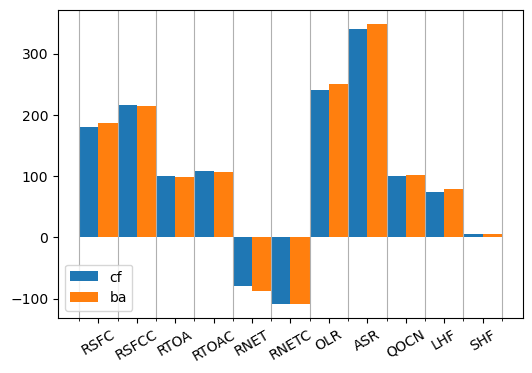

In [15]:
# 2D comparisons (like in comp_rcemip)
#### user input ####
plot_type="rad" #options: "rad" for radiation, "water" for hydrometeors
plot=True
#### end user input ####
var_list_rad = ["RSFC", "RSFCC","RTOA","RTOAC","RNET","RNETC","OLR","ASR","QOCN","LHF","SHF"]
var_list_water = ["PW","PR","LWP","IWP","WVP"]
fig, ax = plt.subplots(1,1,figsize=(6,4))
savename=plot_type+"_"
for i in range(len(runs)):
    ds = xr.open_dataset(run_dir+"scream_dp_RCE_SMALL_3km_{}/run/scream_dp_RCE_SMALL_3km_{}.eam.h1.2000-01-01-00000.nc".format(runs[i],runs[i]))
    ds = ds.isel(time=slice(-ndays, -1))
    var_dict = {}
    savename = savename + runs[i][-2:] + "-"
    if plot_type=="rad":
        # rsfc, the net radiative flux at the sfc (SW-LW)
        var_dict["RSFC"] = (ds["FSNS"]-ds["FLNS"]).mean()
        var_dict["RSFCC"] = (ds["FSNSC"]-ds["FLNSC"]).mean()
        # rtoa, the net radiative flux at toa (SW-LW)
        var_dict["RTOA"] = (ds["FSNTOA"]-ds["FLUT"]).mean()
        var_dict["RTOAC"] = (ds["FSNTOAC"]-ds["FLUTC"]).mean()
        # rnet = rtoa − rsfc, where negative values indicate net atmospheric radiative cooling
        var_dict["RNET"] = ((ds["FSNTOA"]-ds["FLUT"]) - (ds["FSNS"]-ds["FLNS"])).mean()
        var_dict["RNETC"] = ((ds["FSNTOAC"]-ds["FLUTC"]) - (ds["FSNSC"]-ds["FLNSC"])).mean()
        # olr
        var_dict["OLR"] = ds["FLUT"].mean()
        # asr, absorbed sw radiation (i.e., net SW flux at TOA (total incoming - total outgoing))
        var_dict["ASR"] = ds["FSNTOA"].mean()
        # energy input into ocean
        var_dict["QOCN"] = ((ds["FSNS"]-ds["FLNS"])-ds["LHFLX"]-ds["SHFLX"]).mean()
        # lhf, latent heat flux
        var_dict["LHF"] = ds["LHFLX"].mean()
        # shf, sensible heat flux
        var_dict["SHF"] = ds["SHFLX"].mean()
        units_dict = zip(var_list_rad,["W/m2"]*len(var_list_rad))
    else: #plot_type=="water"
        # pw, precipitable water
        var_dict["PW"] = ds["TMQ"].mean()
        # precip, precipitation rate
        var_dict["PR"] = ((ds.PRECL)*1000*3600*24).mean() #m/s --> mm/day ==> m/s * 1000 mm/m * 3600s/1hr * 24hr/day = mm/day
        # LWP, liquid water path
        var_dict["LWP"] = ds["TGCLDLWP"].mean()
        # IWP, ice water path
        var_dict["IWP"] = ds["TGCLDIWP"].mean()
        # clwvi_avg, water vapor path
        var_dict["WVP"] = ds["TGCLDCWP"].mean()
        units_dict = zip(var_list_water,["kg/m2","mm/day","kg/m2","kg/m2","kg/m2"])
    # plot
    if plot_type=="rad":
        var_list=var_list_rad
    else:
        var_list=var_list_water
        if i==0:
            axt = ax.twinx()
    for j in range(len(var_list)):
        ci = "C0" if i==0 else "C1"
        if j==0:
            ax.bar(j+(i/len(runs)),var_dict[var_list[j]], color=ci, width=0.5, label=runs[i])
        else:
            if (plot_type=="water") & (j>1):
                axt.bar(j+(i/len(runs)),var_dict[var_list[j]], color=ci, width=0.5)
                axt.set_yscale("log")
                axt.axvline(1.75, color='k')
                axt.set_ylim([1e-2,3e-1])
            else:
                ax.bar(j+(i/len(runs)),var_dict[var_list[j]], color=ci, width=0.5)
ax.set_xticks(np.arange(0.25,len(var_list),1), var_list)
ax.set_xticks(np.arange(-0.25,len(var_list),1), minor=True)
ax.tick_params(axis='x', labelrotation=30)
ax.legend(loc=3)
ax.grid(axis='x', which='minor')
print("save as plots/compare_runs_{}.png".format(savename[:-1]))
plt.savefig("plots/compare_runs_{}.png".format(savename[:-1]))
plt.show()